# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [143]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/hanaebm/mlfs-book


In [144]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [145]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 14, 16, 54, 17, 554637)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [146]:
project = hopsworks.login()
fs = project.get_feature_store() 
import argparse, json

parser = argparse.ArgumentParser()
parser.add_argument("--id", type=int, default=1)
args, _ = parser.parse_known_args()
id=args.id
import os
id = int(os.environ.get("id", 1))

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret(f"SENSOR_{id}_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-14 16:54:18,810 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-14 16:54:18,842 INFO: Initializing external client
2025-11-14 16:54:18,844 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-14 16:54:19,772 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-14 16:54:20,934 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271987


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [147]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name=f"air_quality_xgboost_model_{id}",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-14 16:54:26,178 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/465703 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/47448 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25984 elapsed<00:00 remaining<?

In [148]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + f"/model_{id}.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.702841E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [149]:
weather_fg = fs.get_feature_group(
    name=f'weather_{id}',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name=f'air_quality_{id}',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()

batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,5.05,0.0,13.104198,217.184784,asmundtorp
1,2025-11-15 00:00:00+00:00,3.30,0.0,5.400000,53.130020,asmundtorp
2,2025-11-16 00:00:00+00:00,5.40,0.0,17.935081,231.519775,asmundtorp
3,2025-11-17 00:00:00+00:00,3.35,0.3,18.328207,315.000092,asmundtorp
4,2025-11-19 00:00:00+00:00,4.65,0.0,8.121970,257.195740,ramshogsvagen
5,2025-11-17 00:00:00+00:00,3.65,0.0,17.555307,331.858490,ramshogsvagen
6,2025-11-15 00:00:00+00:00,5.30,0.0,13.276144,77.471199,ramshogsvagen
7,2025-11-18 00:00:00+00:00,5.45,0.0,13.979871,258.111359,ramshogsvagen
8,2025-11-16 00:00:00+00:00,5.55,0.0,10.495713,300.963684,ramshogsvagen
9,2025-11-20 00:00:00+00:00,4.25,0.6,5.904439,232.431335,ramshogsvagen


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [150]:
import numpy as np
import pandas as pd
import datetime

# Initialisation des colonnes
for lag in range(1, 4):
    batch_data[f"pm25_lag_{lag}"] = np.nan
batch_data["predicted_pm25"] = np.nan

# Trier les données par date
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

# Récupérer "today" depuis batch_data
today = batch_data.loc[0, "date"]
if not isinstance(today, pd.Timestamp):
    today = pd.Timestamp(today, tz='UTC')

# Lire toutes les données du Feature Group dans un DataFrame Pandas
air_quality_df = air_quality_fg.read()  # <-- maintenant on a un DataFrame Pandas

# S'assurer que la colonne date est bien en datetime
air_quality_df['date'] = pd.to_datetime(air_quality_df['date'], utc=True)

# Remplissage de la première ligne
for lag in [1, 2, 3]:
    date_to_fetch = today - pd.Timedelta(days=lag-1)
    feature_name = f"pm25_lag_{lag}"

    # Filtrer par date uniquement
    filtered_df = air_quality_df[air_quality_df['date'].dt.date == date_to_fetch.date()]

    if not filtered_df.empty:
        if feature_name in filtered_df.columns:
            batch_data.loc[0, feature_name] = filtered_df.iloc[0][feature_name]
        else:
            batch_data.loc[0, feature_name] = filtered_df.iloc[0]["pm25"]  # ajuster si nécessaire

# Colonnes pour le modèle
cols = ["pm25_lag_1","pm25_lag_2","pm25_lag_3",
        "temperature_2m_mean","precipitation_sum",
        "wind_speed_10m_max","wind_direction_10m_dominant"]

# Première prédiction
batch_data.loc[0, "predicted_pm25"] = retrieved_xgboost_model.predict(
    batch_data.loc[[0], cols]
)[0]

# Remplissage des lignes suivantes
for i in range(1, len(batch_data)):
    batch_data.loc[i, "pm25_lag_1"] = batch_data.loc[i-1, "predicted_pm25"]
    batch_data.loc[i, "pm25_lag_2"] = batch_data.loc[i-1, "pm25_lag_1"]
    batch_data.loc[i, "pm25_lag_3"] = batch_data.loc[i-1, "pm25_lag_2"]

    batch_data.loc[i, "predicted_pm25"] = retrieved_xgboost_model.predict(
        batch_data.loc[[i], cols]
    )[0]

batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.29s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2025-11-15 00:00:00+00:00,3.30,0.0,5.400000,53.130020,asmundtorp,NaN,5.000000,18.170000,87.308372
1,2025-11-15 00:00:00+00:00,5.30,0.0,13.276144,77.471199,ramshogsvagen,87.308372,NaN,5.000000,94.680130
2,2025-11-16 00:00:00+00:00,5.40,0.0,17.935081,231.519775,asmundtorp,94.680130,87.308372,NaN,49.554600
3,2025-11-16 00:00:00+00:00,5.55,0.0,10.495713,300.963684,ramshogsvagen,49.554600,94.680130,87.308372,23.956266
4,2025-11-17 00:00:00+00:00,3.35,0.3,18.328207,315.000092,asmundtorp,23.956266,49.554600,94.680130,19.891624
5,2025-11-17 00:00:00+00:00,3.65,0.0,17.555307,331.858490,ramshogsvagen,19.891624,23.956266,49.554600,29.301054
6,2025-11-18 00:00:00+00:00,5.05,0.0,13.104198,217.184784,asmundtorp,29.301054,19.891624,23.956266,38.040676
7,2025-11-18 00:00:00+00:00,5.45,0.0,13.979871,258.111359,ramshogsvagen,38.040676,29.301054,19.891624,30.810715
8,2025-11-19 00:00:00+00:00,4.65,0.0,8.121970,257.195740,ramshogsvagen,30.810715,38.040676,29.301054,35.764050
9,2025-11-20 00:00:00+00:00,4.25,0.6,5.904439,232.431335,ramshogsvagen,35.764050,30.810715,38.040676,33.553932


In [151]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          10 non-null     float32                
 2   precipitation_sum            10 non-null     float32                
 3   wind_speed_10m_max           10 non-null     float32                
 4   wind_direction_10m_dominant  10 non-null     float32                
 5   city                         10 non-null     object                 
 6   pm25_lag_1                   9 non-null      float64                
 7   pm25_lag_2                   9 non-null      float64                
 8   pm25_lag_3                   9 non-null      float64                
 9   predicted_pm25               10 non-null     float64                
dtypes: da

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [152]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,3.30,0.0,5.400000,53.130020,ramshogsvagen,NaN,5.000000,18.170000,87.308372,dosjebro,sweden,1
1,2025-11-15 00:00:00+00:00,5.30,0.0,13.276144,77.471199,ramshogsvagen,87.308372,NaN,5.000000,94.680130,dosjebro,sweden,2
2,2025-11-16 00:00:00+00:00,5.40,0.0,17.935081,231.519775,ramshogsvagen,94.680130,87.308372,NaN,49.554600,dosjebro,sweden,3
3,2025-11-16 00:00:00+00:00,5.55,0.0,10.495713,300.963684,ramshogsvagen,49.554600,94.680130,87.308372,23.956266,dosjebro,sweden,4
4,2025-11-17 00:00:00+00:00,3.35,0.3,18.328207,315.000092,ramshogsvagen,23.956266,49.554600,94.680130,19.891624,dosjebro,sweden,5
5,2025-11-17 00:00:00+00:00,3.65,0.0,17.555307,331.858490,ramshogsvagen,19.891624,23.956266,49.554600,29.301054,dosjebro,sweden,6
6,2025-11-18 00:00:00+00:00,5.05,0.0,13.104198,217.184784,ramshogsvagen,29.301054,19.891624,23.956266,38.040676,dosjebro,sweden,7
7,2025-11-18 00:00:00+00:00,5.45,0.0,13.979871,258.111359,ramshogsvagen,38.040676,29.301054,19.891624,30.810715,dosjebro,sweden,8
8,2025-11-19 00:00:00+00:00,4.65,0.0,8.121970,257.195740,ramshogsvagen,30.810715,38.040676,29.301054,35.764050,dosjebro,sweden,9
9,2025-11-20 00:00:00+00:00,4.25,0.6,5.904439,232.431335,ramshogsvagen,35.764050,30.810715,38.040676,33.553932,dosjebro,sweden,10


In [153]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          10 non-null     float32                
 2   precipitation_sum            10 non-null     float32                
 3   wind_speed_10m_max           10 non-null     float32                
 4   wind_direction_10m_dominant  10 non-null     float32                
 5   city                         10 non-null     object                 
 6   pm25_lag_1                   9 non-null      float64                
 7   pm25_lag_2                   9 non-null      float64                
 8   pm25_lag_3                   9 non-null      float64                
 9   predicted_pm25               10 non-null     float64                
 10  stree

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

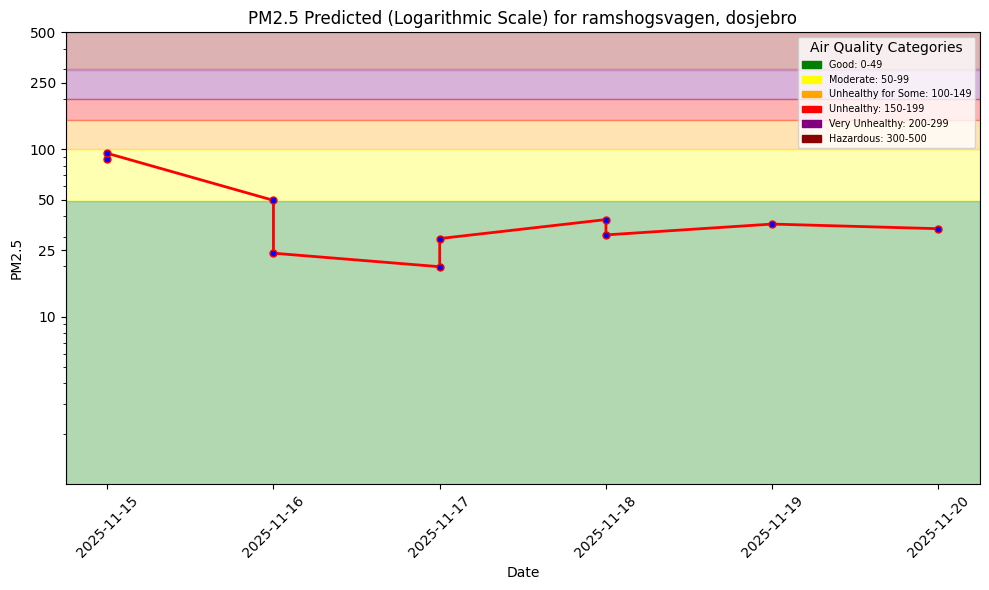

In [154]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{id}.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [155]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions_{id}',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [156]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271987/jobs/named/aq_predictions_2_1_offline_fg_materialization/executions
2025-11-14 16:55:08,496 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-14 16:55:11,694 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 16:56:40,093 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-14 16:56:43,402 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 16:56:43,649 INFO: Waiting for log aggregation to finish.
2025-11-14 16:57:00,535 INFO: Execution finished successfully.


(Job('aq_predictions_2_1_offline_fg_materialization', 'SPARK'), None)

In [157]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.50s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,5.050000,0.0,13.104198,217.184784,asmundtorp,NaN,NaN,NaN,52.066605,kustvagen,sweden,1
1,2025-11-03 00:00:00+00:00,9.476416,5.8,28.647722,210.334442,asmundtorp,0.0,0.07,0.10,0.053463,kustvagen,sweden,1
2,2025-11-10 00:00:00+00:00,6.972250,0.0,6.240577,86.516815,asmundtorp,0.1,0.10,0.10,0.131166,kustvagen,sweden,1
3,2025-11-05 00:00:00+00:00,11.170167,0.0,22.737783,179.668228,asmundtorp,0.0,0.10,0.00,0.015501,kustvagen,sweden,1
4,2025-11-06 00:00:00+00:00,10.184750,0.0,16.712881,144.643311,asmundtorp,0.0,0.00,0.10,0.003540,kustvagen,sweden,1
5,2025-11-08 00:00:00+00:00,8.141000,0.1,10.601679,143.882248,asmundtorp,0.1,0.00,0.00,0.152259,kustvagen,sweden,1
6,2025-11-11 00:00:00+00:00,8.230582,1.6,17.258425,186.143188,asmundtorp,0.1,0.10,0.10,-0.110502,kustvagen,sweden,1
7,2025-11-12 00:00:00+00:00,10.150000,0.1,23.803596,183.468155,asmundtorp,0.0,0.00,0.00,-0.186759,kustvagen,sweden,1
8,2025-11-07 00:00:00+00:00,8.074334,0.0,21.827551,143.929443,asmundtorp,0.0,0.00,0.00,0.075305,kustvagen,sweden,1
9,2025-11-04 00:00:00+00:00,12.005584,2.0,27.858162,210.026260,asmundtorp,0.1,0.00,0.07,0.024459,kustvagen,sweden,1


In [158]:
air_quality_fg = fs.get_feature_group(name=f'air_quality_{id}', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.34s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2024-04-27 00:00:00+00:00,0.10,sweden,asmundtorp,kustvagen,https://api.waqi.info/feed/A62566/,0.20,0.100000,0.100000
1,2021-07-31 00:00:00+00:00,2.63,sweden,asmundtorp,kustvagen,https://api.waqi.info/feed/A62566/,2.20,2.170000,6.290000
2,2021-05-05 00:00:00+00:00,9.00,sweden,asmundtorp,kustvagen,https://api.waqi.info/feed/A62566/,37.00,39.000000,17.000000
3,2023-04-22 00:00:00+00:00,0.00,sweden,asmundtorp,kustvagen,https://api.waqi.info/feed/A62566/,0.00,0.000000,0.100000
4,2022-11-03 00:00:00+00:00,0.00,sweden,asmundtorp,kustvagen,https://api.waqi.info/feed/A62566/,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
3637,2020-12-17 00:00:00+00:00,17.60,sweden,ramshogsvagen,dosjebro,https://api.waqi.info/feed/A82942/,9.41,16.290001,16.299999
3638,2024-02-21 00:00:00+00:00,4.22,sweden,ramshogsvagen,dosjebro,https://api.waqi.info/feed/A82942/,4.63,4.590000,7.130000
3639,2024-09-21 00:00:00+00:00,9.43,sweden,ramshogsvagen,dosjebro,https://api.waqi.info/feed/A82942/,9.35,4.590000,6.950000
3640,2020-06-08 00:00:00+00:00,1.87,sweden,ramshogsvagen,dosjebro,https://api.waqi.info/feed/A82942/,2.31,1.250000,1.100000


In [159]:
import importlib
importlib.reload(util)

<module 'mlfs.airquality.util' from '/home/hanaebm/mlfs-book/mlfs/airquality/util.py'>

In [160]:
outcome_df = air_quality_df[['date', 'pm25']]
monitoring_df['predicted_pm25']=monitoring_df['predicted_pm25'].astype('float64')

preds_df =  monitoring_df[['date', 'predicted_pm25']]


hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

features_df = air_quality_fg.select(['date','pm25_lag_1','pm25_lag_2','pm25_lag_3','city']).join(
    weather_fg.select_features(), on=['city']
).read()  

for col in ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']:
    if col in features_df.columns:
        features_df[col] = features_df[col].astype('float64')

    
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(features_df, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

2025-11-14 16:57:05,156 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_2` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.39s) 


,date,predicted_pm25,pm25
0,2025-11-03 00:00:00+00:00,0.053463,0.100000
1,2025-11-03 00:00:00+00:00,0.053463,11.090000
17,2025-11-04 00:00:00+00:00,0.024459,999.900024
16,2025-11-04 00:00:00+00:00,0.024459,0.000000
4,2025-11-05 00:00:00+00:00,0.015501,0.000000
5,2025-11-05 00:00:00+00:00,0.015501,999.900024
6,2025-11-06 00:00:00+00:00,0.003540,0.000000
7,2025-11-06 00:00:00+00:00,0.003540,999.900024
15,2025-11-07 00:00:00+00:00,0.075305,999.900024
14,2025-11-07 00:00:00+00:00,0.075305,0.100000


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

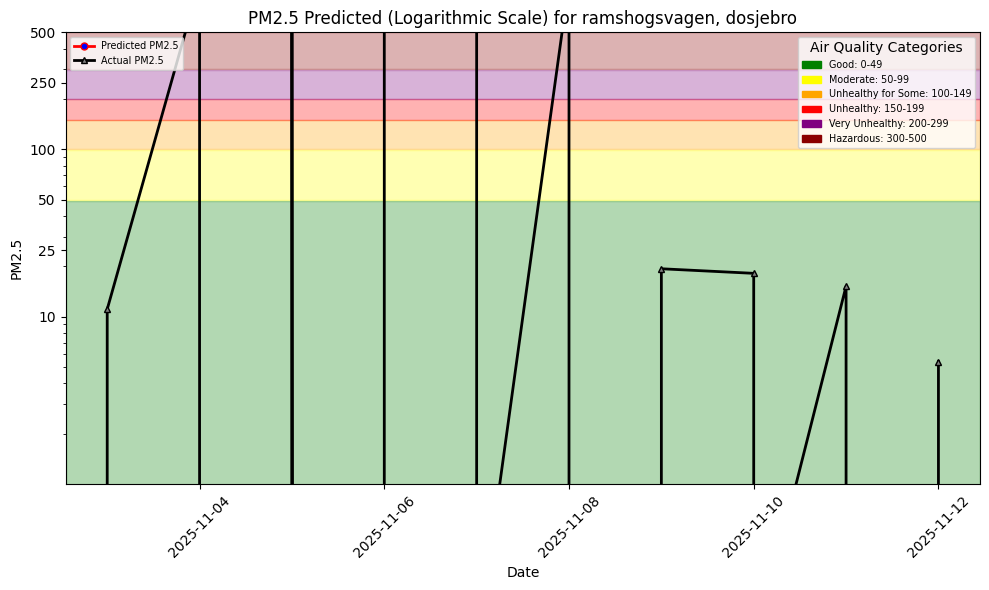

In [161]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{id}.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [84]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/hanaebm/mlfs-book/docs/air-quality/assets/img/pm25_forecast_1.png: 0.000%|          | 0/47114 …

Uploading /home/hanaebm/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_1.png: 0.000%|          | 0/5…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1271987/settings/fb/path/Resources/airquality


---